## IDs:
ID 1: 204502926 <br>
ID 2: 000000000

## Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

### Question 1: Data exploration (15 points)

#### Answer:

In [7]:
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False): 
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=5, bbox={'facecolor':'k', 'pad':5},color='w')
    ax.set_xlabel(xlab, fontsize=16, labelpad=10)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    plt.xticks(rotation=45)
    plt.hist(dataset[attribute], bins=50, color=bar_color, ec=edge_color, linewidth=2)

Sparsity: 0.9369533063577546



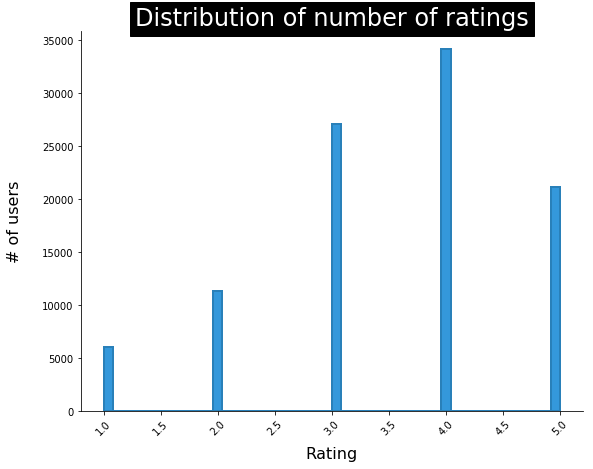

In [9]:
# Calculate the dataset sparsity, distribution of number of ratings as well as the average rating value per user\item. 
# Include additional exploration you find relevant to questions 2 and 3.
# Discuss your insights and possible challenges related to the prediction task described in question 2.


# Remember that sparsity is calculated by the number of cells in a matrix that contain a rating divided by the total number of values that matrix could hold given the number of users and items (movies). 
# In other words, dividing the number of ratings present in the matrix by the product of users and movies in the matrix and subtracting that from 1 will give us the sparsity or the percentage of the ratings matrix that is empty.

file_path = 'ml-100k/u.data' # grouplens.org/datasets/movielens/100k
users = 943
items = 1682
ratings = 100000 # OR sum(1 for line in open(file_path))
sparsity = 1 - (ratings / (users * items))
print(f'Sparsity: {sparsity}')
print()

data = pd.read_csv(file_path, delimiter='\t', header=None, names=(['user id', 'item id', 'rating', 'timestamp']))
# print(data.head())
# data.isnull().sum() # Not a single value is missing

make_histogram(data, 'rating', title='Distribution of number of ratings', xlab='Rating', ylab='# of users')

We can see that **'4'** is the dominant rating (34,174 ratings)<br>
The average rating is: $\frac{\sum_{i=1}^n(i * y(i))}{|S|}$, where i is a rating value (1-5), y(i) is the amount of ratings per user/item, and |S| is the size of the dataset (100K).<br>
We can also see that the users are more prone to give a perfect rating ('5') rather than < '3'.

In [4]:
average = sum(data['rating']) / len(data['rating'])
print(f'The average rating is {average}')

The average rating is 3.52986



### Question 2: Matrix factorization model implementation and evaluation (60 points)

#### Answer:

### Question 3: Matrix factorization – item similarity and model explainability (25 points)

#### Answer: